In [1]:
REPO_NAME = "BSides-Nova-BreakAI-Workshop-2025"
!git clone https://github.com/pavanreddyml/{REPO_NAME}.git
!mv {REPO_NAME}/* . && mv {REPO_NAME}/.* . 2>/dev/null
!rm -rf {REPO_NAME}
!pip install -e bsidesnova

!git clone https://github.com/pavanreddyml/adversarial-lab.git
!pip install -e adversarial-lab

Cloning into 'BSides-Nova-BreakAI-Workshop-2025'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 163 (delta 33), reused 131 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (163/163), 1.74 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (33/33), done.
mv: cannot move 'BSides-Nova-BreakAI-Workshop-2025/assets' to './assets': Directory not empty
mv: cannot move 'BSides-Nova-BreakAI-Workshop-2025/bsidesnova' to './bsidesnova': Directory not empty
Obtaining file:///content/bsidesnova
  Preparing metadata (setup.py) ... done
  Attempting uninstall: bsidesnova
    Found existing installation: bsidesnova 0.0.1
    Uninstalling bsidesnova-0.0.1:
      Successfully uninstalled bsidesnova-0.0.1
  Running setup.py develop for bsidesnova
fatal: destination path 'adversarial-lab' already exists and is not an empty directory.
Obtaining file:///content/adversarial-lab
  Installing bui

In [5]:
import IPython
IPython.Application.instance().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [1]:
from bsidesnova import *

from adversarial_lab.analytics import *
from adversarial_lab.db import SqlliteDB
from adversarial_lab.callbacks import EarlyStopping
from adversarial_lab.core.optimizers import PGD
from adversarial_lab.core.penalties import LpNorm
from adversarial_lab.core.losses import CategoricalCrossEntropy
from adversarial_lab.attacker.adversarial import WhiteBoxMisclassificationAttack
from adversarial_lab.core.noise_generators.tensor import AdditiveNoiseGenerator
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.core.constraints import POClip, PONoisedSampleBounding
from adversarial_lab.arsenal.attacks_base import AttacksBase

from adversarial_lab.utils import VideoPlotter, Plotting

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from bsidesnova.selectors import *
from bsidesnova.ui import *

In [10]:
widget = AttackSelectorUI()
widget.display()

In [21]:
selector = AdversarialSelector(root_path="")
conf = widget.get_configuration()
att_conf = selector.attacker_selector(conf)
att_conf["on_origial"] = True

In [22]:
if conf["attack"] in ["Deep Fool", "Smooth Fool"]:
  early_stopping = EarlyStopping(trigger="misclassification")
else:
  early_stopping = EarlyStopping(trigger="misclassification", target_class=2, confidence=0.5)


In [23]:
db = SqlliteDB(db_path="whitebox.db")
analytics = AdversarialAnalytics(
    db=db,
    trackers=[
        ImageTracker(),
        LossTracker(),
        NoiseStatisticsTracker(),
        NoiseTracker(),
        PredictionsTracker()
    ],
    table_name="adv",
    force_create_table=True

)

In [24]:
attacker_class = att_conf["attacker"]
model = att_conf["model"]
preprocess = att_conf["preprocess"]
attack_params = att_conf["attack_params"]
input_shape = att_conf["input_shape"]
sample = att_conf["sample"]
decode_preds = att_conf["decode_preds"]
target_class = att_conf["target_class"]

attack_params["analytics"] = analytics
attack_params["callbacks"] = [early_stopping]

In [25]:
attacker: AttacksBase = attacker_class(model=model, preprocessing_fn=PreprocessingFromFunction.create(preprocess), **attack_params)
noise, noise_meta = attacker.attack(sample=sample, target_class=60, epochs=20)

Attacking: 100%|██████████| 20/20 [00:54<00:00,  2.71s/it, Loss=5e+3, Prediction (score)=921(0.102)]   

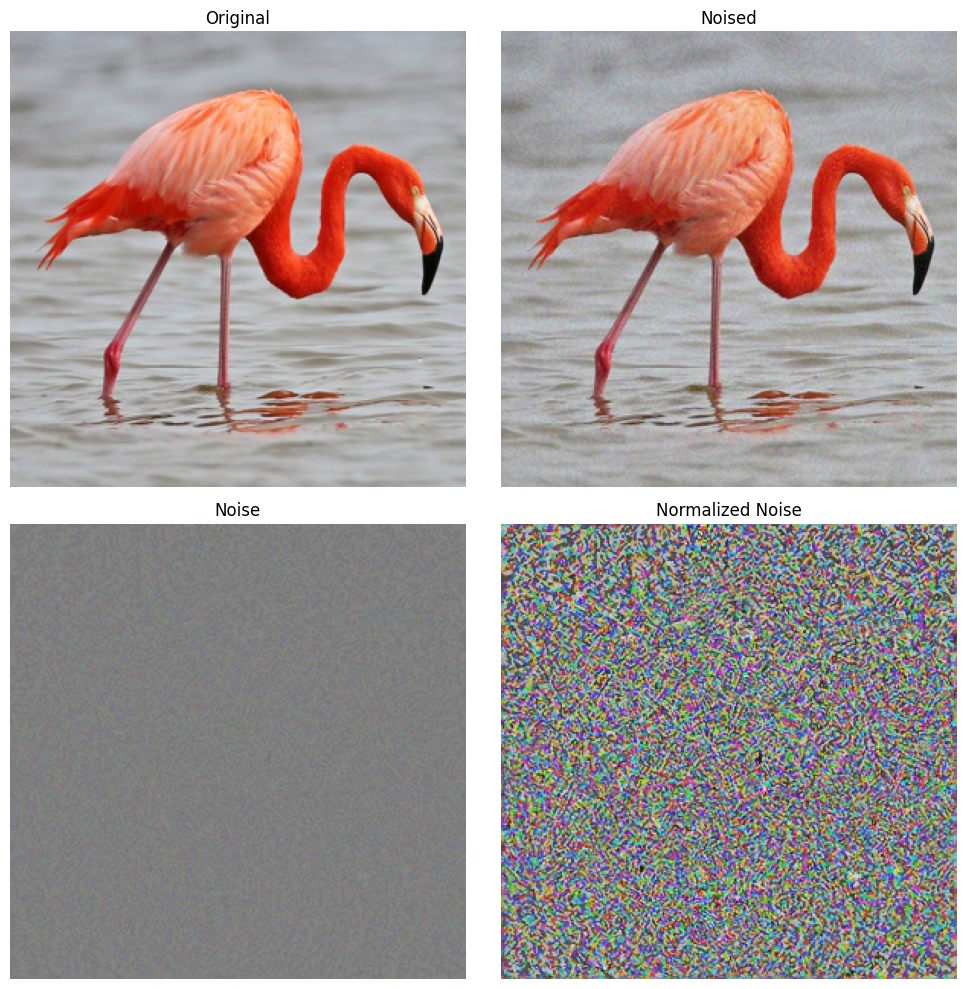

In [26]:
plotter = Plotting(db=db, table_name="adv")
plotter.plot_losses()
plotter.plot_predictions(n=5)
plotter.plot_noise_statistics("mean")
plotter.plot_samples(
    image=sample,
        noise=noise,
        config=None,
        class_dict=None,
        original_class_idx=None,
        predicted_class_idx=None,
        original_confidence=None,
        predicted_confidence=None)

In [27]:
plotter = VideoPlotter(db=db, table_name="adv")
plotter.make_video()

Rendering frames: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 2100) to (1008, 2112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Encoding video: 100%|██████████| 20/20 [00:00<00:00, 44.96it/s]


Video saved to output_video.mp4


In [28]:
# display the generated adversarial video output_video.mp4
from IPython.display import Video
Video("output_video.mp4")

In [29]:
from adversarial_lab.defenses.preprocessing import *

ModuleNotFoundError: No module named 'random_resize_pad'

In [ ]:
# Preprocessing UI (Checkboxes and Randomize, max_num)
# Preprocessing Selector
#